<a href="https://colab.research.google.com/github/susannapaoli/hateful-speech-memes/blob/main/Multimodal%20Experiments/XLNet%2BResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Get data from Kaggle**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
files.upload()

Mounted at /content/drive


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"annalisabarbara","key":"f3e17385dc26a70415d8fbf3d93ef180"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!pwd

/content


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d parthplc/facebook-hateful-meme-dataset

100% 3.35G/3.35G [01:24<00:00, 43.8MB/s]
100% 3.35G/3.35G [01:24<00:00, 42.4MB/s]


In [ ]:
!unzip /content/facebook-hateful-meme-dataset.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: data/img/49758.png      
  inflating: data/img/49762.png      
  inflating: data/img/49785.png      
  inflating: data/img/49786.png      
  inflating: data/img/49802.png      
  inflating: data/img/49805.png      
  inflating: data/img/49806.png      
  inflating: data/img/49807.png      
  inflating: data/img/49810.png      
  inflating: data/img/49826.png      
  inflating: data/img/49831.png      
  inflating: data/img/49832.png      
  inflating: data/img/49836.png      
  inflating: data/img/49850.png      
  inflating: data/img/49856.png      
  inflating: data/img/49861.png      
  inflating: data/img/49863.png      
  inflating: data/img/49867.png      
  inflating: data/img/49870.png      
  inflating: data/img/50124.png      
  inflating: data/img/50126.png      
  inflating: data/img/50129.png      
  inflating: data/img/50137.png      
  inflating: data/img/50142.png      
  inflating: data/img/50146.png      


In [ ]:
!pip install -q transformers
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.8 MB/s eta 0:00:00


In [ ]:
'''
IMPORTING NECESSARY MODULES
'''

import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import sys
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

#sys.path.append('/content/drive/MyDrive/FinalProject/hateful-speech-memes 2/XLNET')
#sys.path.append('/content/drive/MyDrive/FinalProject/hateful-speech-memes 2/multimodal-memes')
#sys.path.append('/content/drive/MyDrive/FinalProject/hateful-speech-memes 2/Utils')
#sys.path.append('/content/drive/MyDrive/FinalProject/hateful-speech-memes 2/Data')
#sys.path.append('/content/drive/MyDrive/FinalProject/hateful-speech-memes 2/Resnet')
#sys.path.append('/content/drive/MyDrive/FinalProject/hateful-speech-memes 2/multimodal-memes/Data/img')

sys.path.append('/content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/XLNET')
sys.path.append('/content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/multimodal-memes')
sys.path.append('/content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/Utils')
sys.path.append('/content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/Data')
sys.path.append('/content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/Resnet')
sys.path.append('/content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/multimodal-memes/Data/img')



from dataloader import myfusiondataset
#from Load_model import load
from plot_curves import plot_loss, plot_acc
from multimodal_trainer import train, test_classify

'''
For ResNet/ ResNeXt
'''
from resnet_model import ResNet,Bottleneck, resnext101_32x8d


'''
For XLNet
'''
from transformers import XLNetForSequenceClassification, AdamW, XLNetConfig
from transformers import get_linear_schedule_with_warmup

**Device**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')
print("You are using device: %s" % device)

You are using device: cuda


**Dataloading Scheme**

In [ ]:
%cd /content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/JSON Data

/content/drive/MyDrive/Deep_Learning/FinalProject/hateful-speech-memes 2/JSON Data


In [ ]:
trainlist = 'train.jsonl'
validlist = 'dev_seen.jsonl'

In [ ]:
'''
Train Dataloader
''' 
train_dataset = myfusiondataset(trainlist, name='train')          
train_dataloader = data.DataLoader(train_dataset, shuffle= True, batch_size = 32, num_workers=8,pin_memory=True)


'''
Validation Dataloader
''' 
validation_dataset = myfusiondataset(validlist, name='valid')         
validation_dataloader = data.DataLoader(validation_dataset, shuffle=False, batch_size = 16, num_workers=8,pin_memory=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_ms

**Model Definition**

In [ ]:
'''
Model1 ResNeXt101_32x8d
'''
Image_model = resnext101_32x8d()

Image_model.fc = nn.Sequential(
    nn.Linear(Image_model.fc.in_features, 2)
    )

Image_model = nn.DataParallel(Image_model).to(device)

Image_model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

In [ ]:
'''
Model 2 XLNet

Load XLNetForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top.
''' 

Text_model = XLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased", 
    num_labels = 2,   
    output_attentions = False, 
    output_hidden_states = True
)

Text_model = nn.DataParallel(Text_model).to(device)


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [ ]:
'''
Fusion
'''
class FusionNet(nn.Module):
    
    def __init__(self, num_classes, drop_prob = 0.1):
        super(FusionNet, self).__init__()
        
        self.pooler = nn.Linear(in_features=768, out_features=768)
        
        self.concat = nn.Linear(in_features=768+2048, out_features= 512)
        
        self.bn = nn.BatchNorm1d(512)
        self.bn1 = nn.BatchNorm1d(768)
        self.bn2 = nn.BatchNorm1d(2048)
    
        self.dropout = nn.Dropout(drop_prob)
        
        self.classify = nn.Linear(in_features = 512, out_features = num_classes)
        
        
    def forward(self, text_features, image_features):
        text_features = torch.tanh(self.pooler(text_features))
        text_features = self.dropout(text_features)

        text_features = self.bn1(text_features)
        image_features = self.bn2(image_features)
      
        fused =  torch.cat((text_features, image_features), dim=1)
      
        x = self.concat(fused)
  
        x = F.tanh(self.bn(x))          
  
        x = F.tanh(self.classify(x)) 
  

        return x



In [ ]:
Fusion_model = FusionNet(num_classes =2 , drop_prob = 0.1)
Fusion_model = nn.DataParallel(Fusion_model).to(device)

In [ ]:
%cd /content/data

/content/data


In [ ]:
#pip install sklearn

**Hyperparameters**

In [ ]:
model_name = 'Concatenation XLNet'
model_path = './saved_model_checkpoints/'+model_name

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
import itertools

def grid_search(model, criterion, hyperparameters):
    best_accuracy = 0
    best_hyperparameters = {}
    hyperparameter_combinations = list(itertools.product(*hyperparameters.values()))

    for combination in hyperparameter_combinations:
        hyperparameter_dict = dict(zip(hyperparameters.keys(), combination))
        print("Testing with hyperparameters: ", hyperparameter_dict)

        optimizer = torch.optim.SGD(model.parameters(), lr=hyperparameter_dict['learning_rate'], 
                                    weight_decay=hyperparameter_dict['weight_decay'], 
                                    momentum=hyperparameter_dict['momentum'])

        num_Epochs = hyperparameter_dict['num_Epochs']
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=hyperparameter_dict['gamma'])

        writer = SummaryWriter(model_name)


        train_loss, v_loss, v_acc = train(Image_model, Text_model, Fusion_model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, model_path, writer, device, epochs = num_Epochs)

        plot_loss(num_Epochs, train_loss, v_loss, 'XLNet + Resnet')

        plot_acc(num_Epochs, v_acc)
        
        
        print(f"{v_acc=} {v_loss=} {hyperparameter_dict['learning_rate'] = } {hyperparameter_dict['weight_decay']=} {hyperparameter_dict['momentum'] = } {hyperparameter_dict['num_Epochs']=}")
        #if v_acc > best_accuracy:
          #best_accuracy = v_acc
          #best_hyperparameters = hyperparameter_dict



        writer.flush()
        writer.close()

        plot_loss(num_Epochs, train_loss, v_loss, 'XLNet + Resnet')

        plot_acc(num_Epochs, v_acc)

    print("\nBest Hyperparameters Found:")
    print(best_hyperparameters)
    print(f"\nBest Validation Accuracy: {best_accuracy:.4f}")
    return best_hyperparameters

Testing with hyperparameters:  {'learning_rate': 0.08, 'gamma': 0.1, 'weight_decay': 1e-05, 'momentum': 0.6, 'num_Epochs': 7}
Epoch:  1
training loss =  0.6902704483136198
Validation Loss: 0.7412	Validation Accuracy: 0.4760
Epoch:  2
training loss =  0.677173804519768
Validation Loss: 0.7409	Validation Accuracy: 0.4700
Epoch:  3
training loss =  0.6525630068061943
Validation Loss: 0.7492	Validation Accuracy: 0.4720
Epoch:  4
training loss =  0.6318326460239583
Validation Loss: 0.7381	Validation Accuracy: 0.5260
Epoch:  5
training loss =  0.615760678635504
Validation Loss: 0.7647	Validation Accuracy: 0.5360
Epoch:  6
training loss =  0.6104026201524233
Validation Loss: 0.7884	Validation Accuracy: 0.5260
Epoch:  7
training loss =  0.6063153830013777
Validation Loss: 0.7831	Validation Accuracy: 0.5280
v_acc=[0.476, 0.47, 0.472, 0.526, 0.536, 0.526, 0.528] v_loss=[0.7411878328323365, 0.7408548994064331, 0.7491573829650879, 0.7380795025825501, 0.7647161056995392, 0.7884131479263305, 0.78305

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch:  1
training loss =  0.6989734038374478
Validation Loss: 0.7003	Validation Accuracy: 0.5080
Epoch:  2
training loss =  0.6957541515952662
Validation Loss: 0.6918	Validation Accuracy: 0.5060
Epoch:  3
training loss =  0.6931646744111427
Validation Loss: 0.6973	Validation Accuracy: 0.5080
Epoch:  4
training loss =  0.6953399891691997
Validation Loss: 0.6931	Validation Accuracy: 0.5080
Epoch:  5
training loss =  0.69401889098318
Validation Loss: 0.6920	Validation Accuracy: 0.5060
Epoch:  6
training loss =  0.6944209435828647
Validation Loss: 0.6920	Validation Accuracy: 0.5060
Epoch:  7
training loss =  0.6943903820855277
Validation Loss: 0.6921	Validation Accuracy: 0.5080
v_acc=[0.508, 0.506, 0.508, 0.508, 0.506, 0.506, 0.508] v_loss=[0.7003026046752929, 0.6917657308578491, 0.6973051414489746, 0.6931472549438477, 0.6920301628112793, 0.6920234184265137, 0.6920599403381348] hyperparameter_dict['learning_rate'] = 0.08 hyperparameter_dict['weight_decay']=1e-05 hyperparameter_dict['momen

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch:  1
training loss =  0.6935919106454778
Validation Loss: 0.6942	Validation Accuracy: 0.5080
Epoch:  2
training loss =  0.6948856267713963
Validation Loss: 0.6957	Validation Accuracy: 0.5100
Epoch:  3
training loss =  0.693838375851624
Validation Loss: 0.6960	Validation Accuracy: 0.5080
Epoch:  4
training loss =  0.6932379849871299
Validation Loss: 0.6952	Validation Accuracy: 0.5080
Epoch:  5
training loss =  0.6942416570688549
Validation Loss: 0.6969	Validation Accuracy: 0.5080
Epoch:  6
training loss =  0.6950228191856155
Validation Loss: 0.6950	Validation Accuracy: 0.5080
Epoch:  7
training loss =  0.6932225316987002
Validation Loss: 0.6960	Validation Accuracy: 0.5080
v_acc=[0.508, 0.51, 0.508, 0.508, 0.508, 0.508, 0.508] v_loss=[0.6942279510498047, 0.695708683013916, 0.6960128440856933, 0.6951648216247559, 0.6969201278686523, 0.6950367698669434, 0.6959615936279296] hyperparameter_dict['learning_rate'] = 0.08 hyperparameter_dict['weight_decay']=1e-05 hyperparameter_dict['moment

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch:  1
training loss =  0.6948445683583281
Validation Loss: 0.6945	Validation Accuracy: 0.5060
Epoch:  2
training loss =  0.6932112115218227
Validation Loss: 0.6931	Validation Accuracy: 0.5060
Epoch:  3
training loss =  0.6931474802637458
Validation Loss: 0.6931	Validation Accuracy: 0.5060
Epoch:  4
training loss =  0.6931474948287907
Validation Loss: 0.6931	Validation Accuracy: 0.5060
Epoch:  5
training loss =  0.6931474800396683
Validation Loss: 0.6931	Validation Accuracy: 0.5060
Epoch:  6
training loss =  0.6934843701975686
Validation Loss: 0.6931	Validation Accuracy: 0.5060
Epoch:  7
training loss =  0.6931474800396683
Validation Loss: 0.6931	Validation Accuracy: 0.5060
v_acc=[0.506, 0.506, 0.506, 0.506, 0.506, 0.506, 0.506] v_loss=[0.6944717597961426, 0.6931473007202148, 0.6931473007202148, 0.6931473007202148, 0.6931473007202148, 0.6931473007202148, 0.6931473007202148] hyperparameter_dict['learning_rate'] = 0.08 hyperparameter_dict['weight_decay']=1e-05 hyperparameter_dict['mom

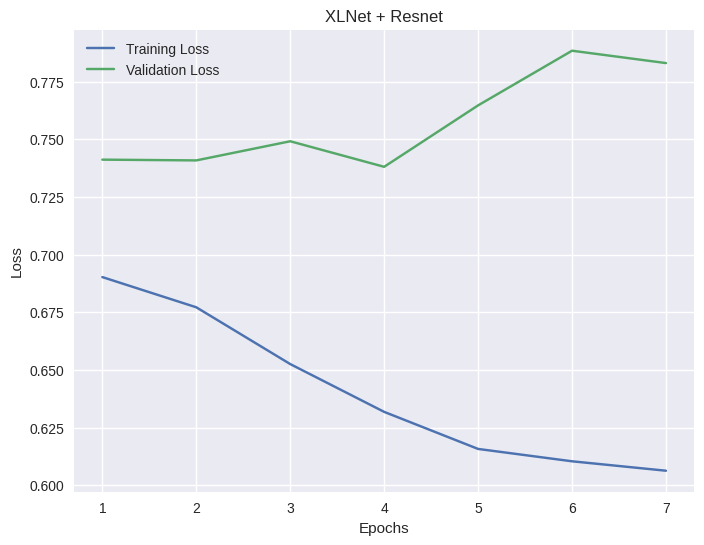

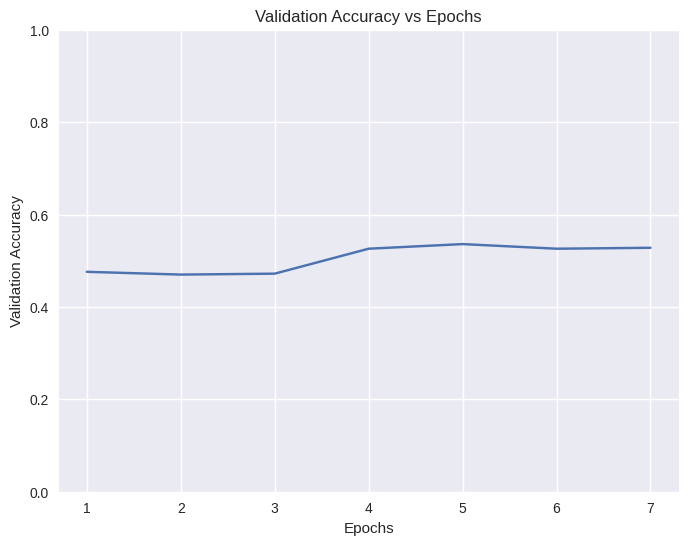

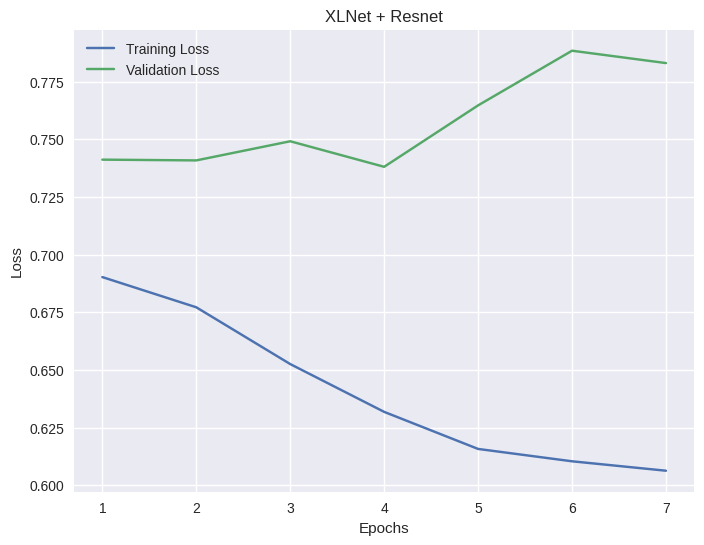

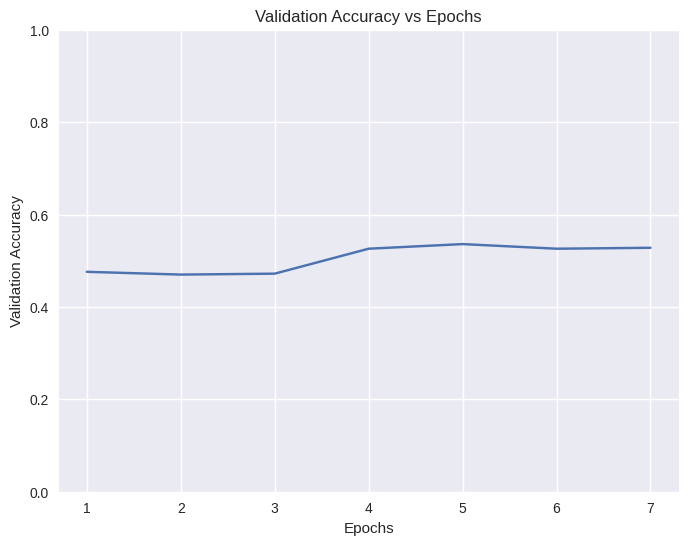

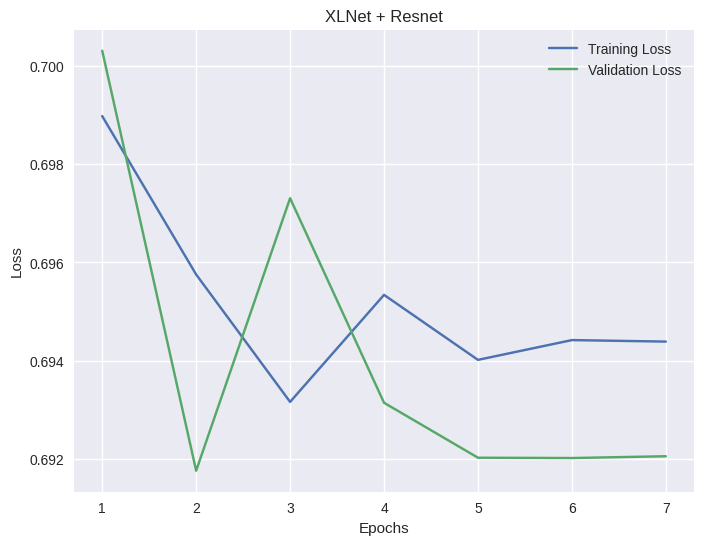

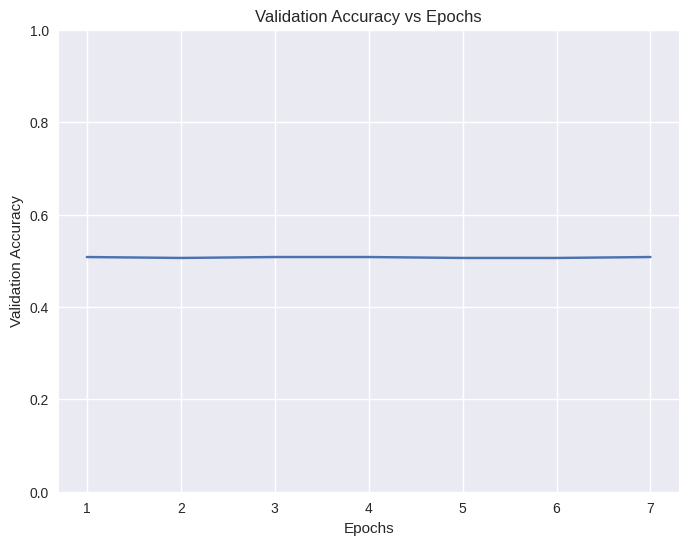

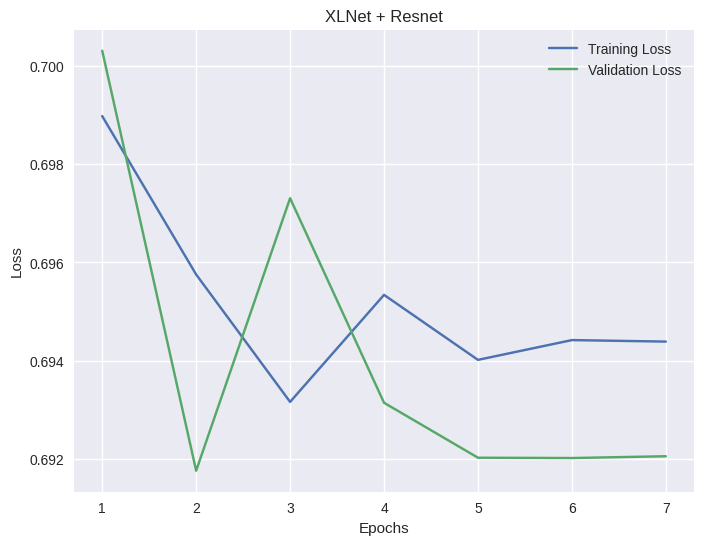

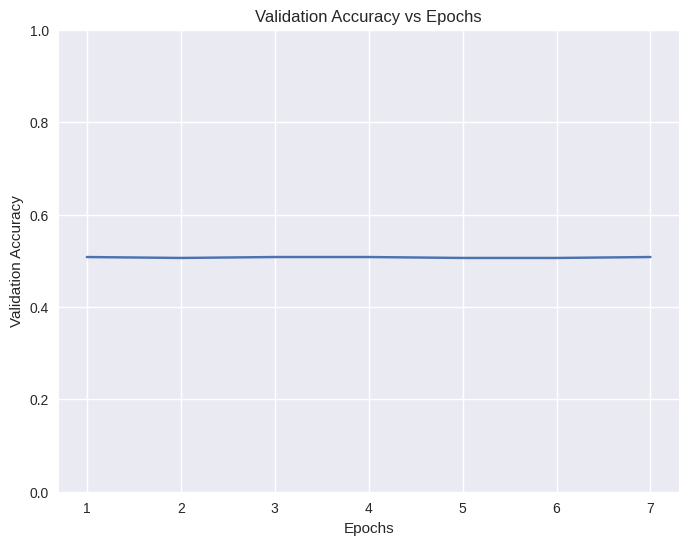

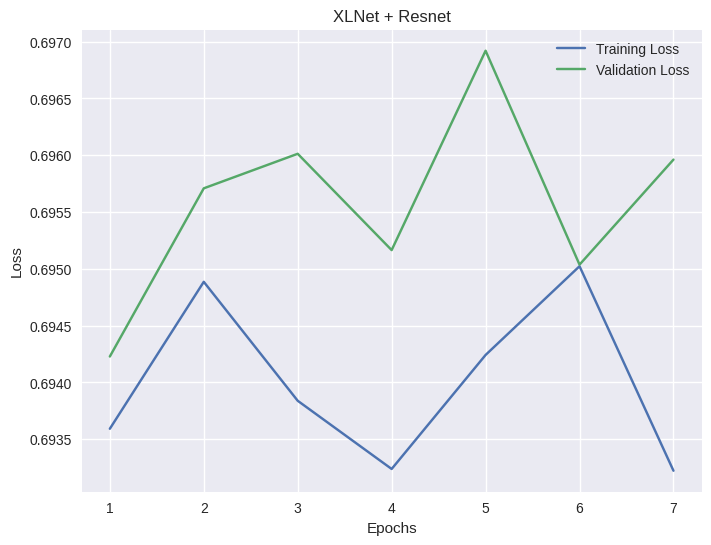

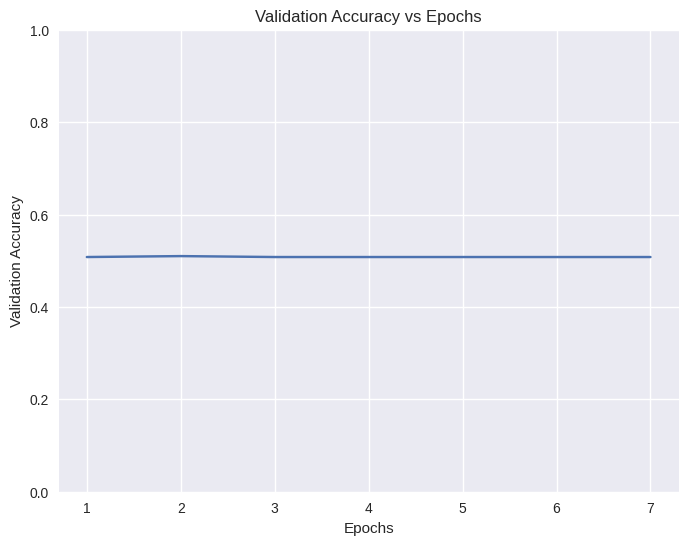

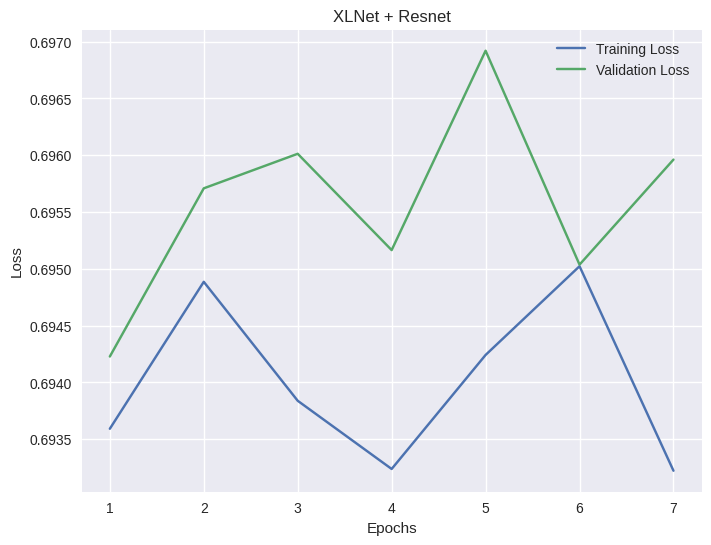

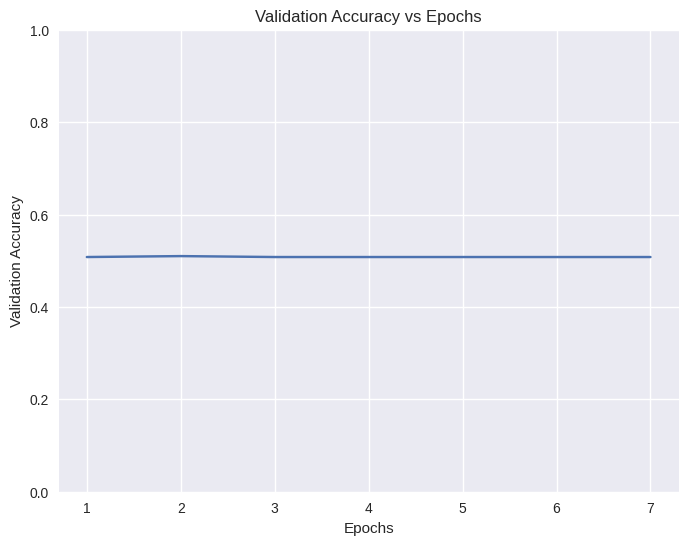

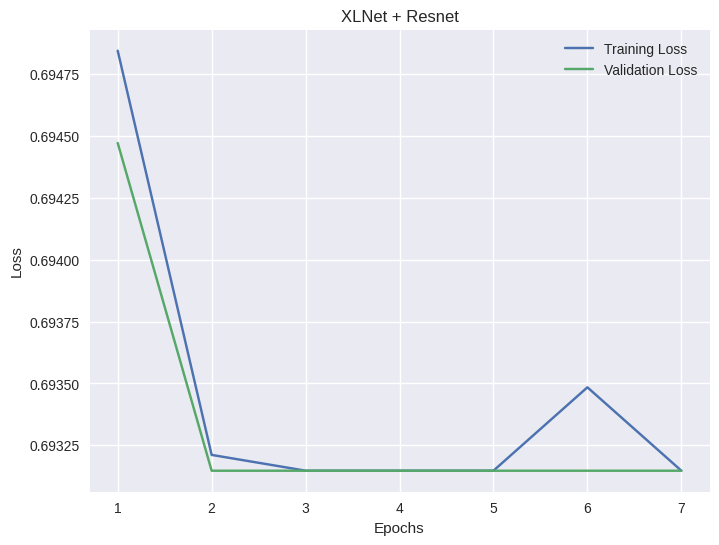

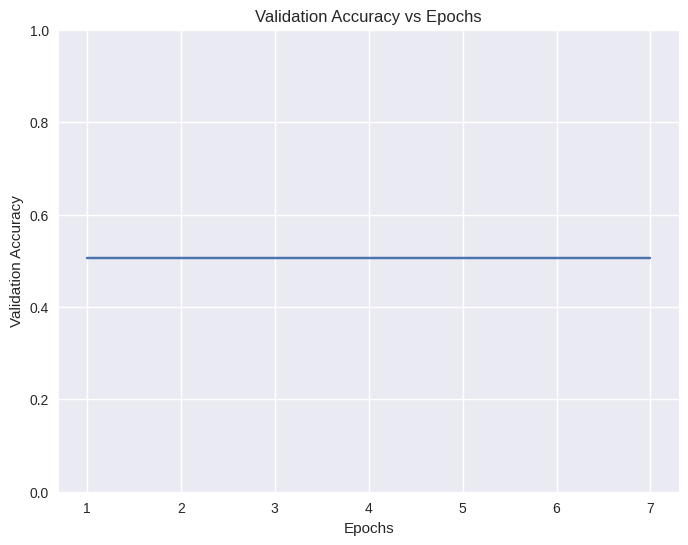

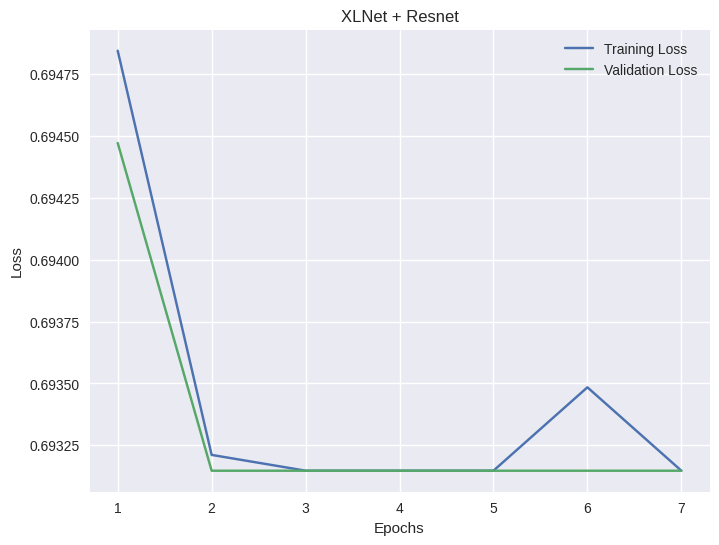

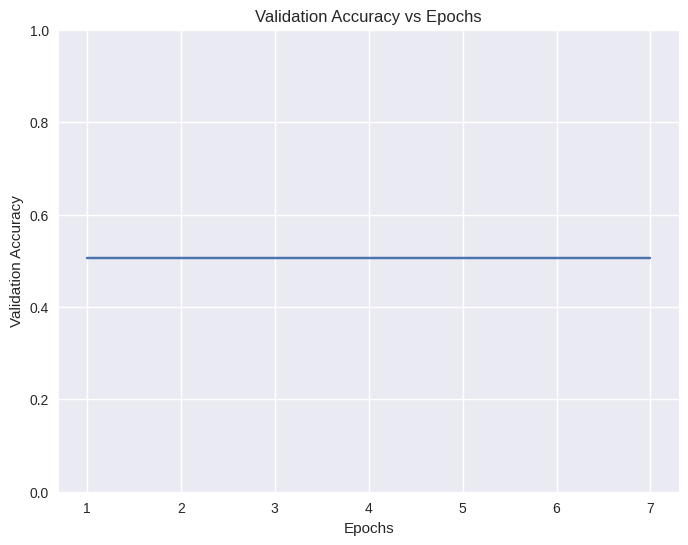

In [ ]:
hyperparameters = {'learning_rate': [0.08],
                   'gamma': [0.1,0.4] ,
                   'weight_decay': [1e-5],
                   'momentum': [ 0.6, 0.99],
                   'num_Epochs': [7]}
best_hyperparameters = grid_search(Fusion_model, criterion, hyperparameters)

In [ ]:
'''
Loss Function
'''
criterion = nn.CrossEntropyLoss()


'''
Optimizer
'''
#optimizer = torch.optim.SGD(Fusion_model.parameters(), lr=0.01, weight_decay=1e-4, momentum=0.9)


# optimizer = torch.optim.Adam(Fusion_model.parameters(), lr=1e-2, weight_decay=1e-4, betas=(0.9, 0.999), eps=1e-8) 
# Epoch: 8
# training loss = 0.6104132024417246
# Validation Loss: 0.7691 Validation Accuracy: 0.5300

# optimizer = torch.optim.Adam(Fusion_model.parameters(), lr=1e-2, weight_decay=1e-4, betas=(0.9, 0.999), eps=1e-8) 
# Epoch:  15
# training loss =  0.5612762393359851
# Validation Loss: 0.7551	Validation Accuracy: 0.5480

# optimizer = torch.optim.SGD(Fusion_model.parameters(), lr=1e-4, weight_decay=1e-4, momentum=0.9)
# Epoch:  5
# training loss =  0.5604842729810485
# Validation Loss: 0.7635	Validation Accuracy: 0.5500

optimizer = torch.optim.SGD(Fusion_model.parameters(), lr=1e-4, weight_decay=1e-4, momentum=0.9)
'''
Number of training epochs.
'''
num_Epochs = 2

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 4, gamma = 0.1)

model_name = 'Concatenation XLNet'
model_path = './saved_model_checkpoints/'+model_name



In [ ]:
writer = SummaryWriter(model_name)

train_loss, v_loss, v_acc = train(Image_model, Text_model, Fusion_model, train_dataloader, validation_dataloader, criterion, optimizer, lr_scheduler, model_path, writer, device, epochs = num_Epochs)

writer.flush()
writer.close()

Epoch:  1
training loss =  0.6596163811540245
Validation Loss: 0.7287	Validation Accuracy: 0.5000
Epoch:  2
training loss =  0.6467537998704982
Validation Loss: 0.7432	Validation Accuracy: 0.4960


**Plots**

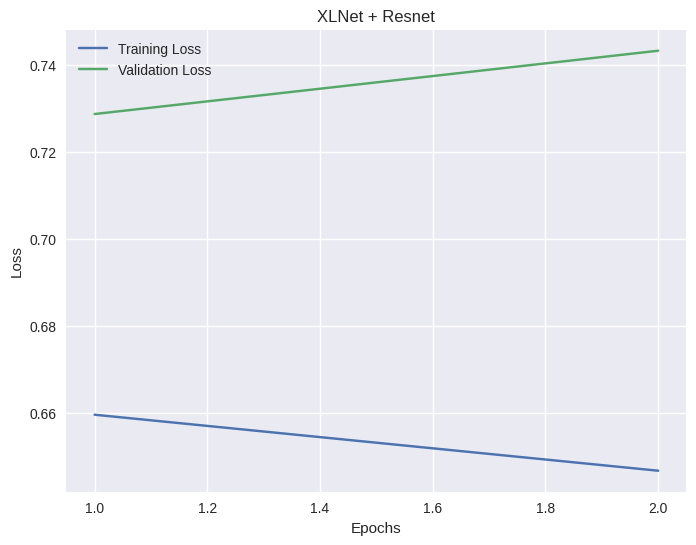

In [ ]:
plot_loss(num_Epochs, train_loss, v_loss, 'XLNet + Resnet')

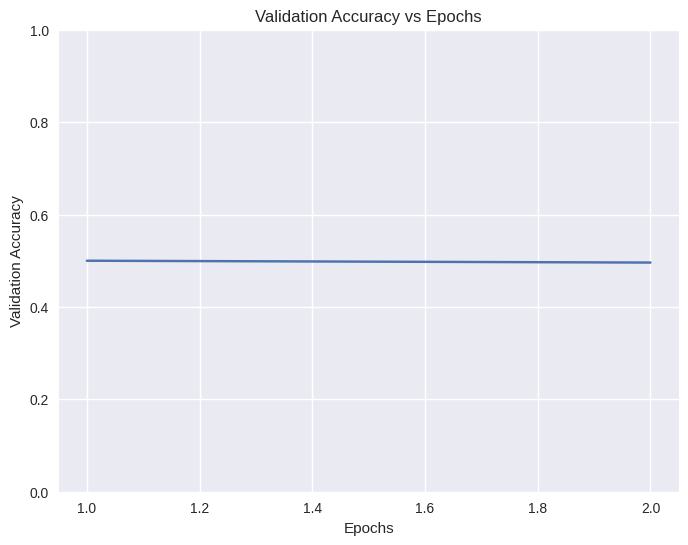

In [ ]:
plot_acc(num_Epochs, v_acc)